In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def reset_columns(df):
    df.columns = ['trade_date', 'symbol','exchange','symbol_in_exchange', 'last_price','prev_settle','prev_close','prev_open_interest',
              'open','high','low','volume','turnover','open_interest','close','settle','limit_up',
              'limit_down','prev_otm','otm','time','millisecond','bid_price1','bid_volume1','ask_price1','ask_volume1',
              'bid_price2','bid_volume2','ask_price2','ask_volume2','bid_price3','bid_volume4','ask_price3','ask_volume3',
              'bid_price4','bid_volume4','ask_price4','ask_volume4','bid_price5','bid_volume5','ask_price5','ask_volume5',
              'avg_price','date'] 

    COLS_TO_DROP = ['exchange','symbol_in_exchange', 'bid_price2','bid_volume2','ask_price2','ask_volume2',
                'bid_price3','bid_volume4','ask_price3','ask_volume3','bid_price4','bid_volume4',
                'ask_price4','ask_volume4','bid_price5','bid_volume5','ask_price5','ask_volume5',
                'prev_otm','otm', 'close', 'settle']
    df = df.drop(COLS_TO_DROP, axis=1)
    return df

In [3]:
def get_trade_time(symbol):
    """ 
    Return trade datettime includes: night/day open, close datetime
    if no break in morning, moring break start/end datetime would be set as monring_trade_end_time
    """
    # Code begins
    night_trade_start_datetime = '21:00:00'
    night_trade_end_datetime = '23:00:00'
    morning_trade_start_datetime = '09:00:00'
    morning_break_start_datetime = '10:15:00'
    morning_break_end_datetime = '10:30:00'
    morning_trade_end_datetime = '11:30:00'
    afternoon_trade_start_datetime = '13:30:00'
    afternoon_trade_end_datetime = '15:00:00'
    
    return (night_trade_start_datetime, night_trade_end_datetime, morning_trade_start_datetime,
    morning_break_start_datetime, morning_break_end_datetime, morning_trade_end_datetime,
    afternoon_trade_start_datetime, afternoon_trade_end_datetime)

In [4]:
def raw2tick(df, symbol='IH'):
    """
    Input: a raw DataFrame downloaded from DataVendor
    Returns: a DataFrame with data only in market open time
    """
    # Code begins
    df = reset_columns(df)
    t = pd.to_timedelta(get_trade_time(symbol))
    td = pd.to_timedelta(df.time.astype(str)) + pd.to_timedelta(df.millisecond * 1000000)
    df = df[
        ((td >= t[0]) & (td <= t[1]))|
        ((td >= t[2]) & (td <= t[3]))|
        ((td >= t[4]) & (td <= t[5]))|
        ((td >= t[6]) & (td <= t[7]))
    ]

    df.index = pd.to_datetime(df.date.astype(str)) + td[df.index]
    
    return df

In [5]:
def tick2min(df):
    """
    Input: a raw DataFrame of market tick data
    Returns: a DataFrame with Open High Low Close price sampled by 1 minute
    resample
    """
    # Code begins
    resampler = df.resample('1min', closed='right', label='left')
    df = resampler.last_price.ohlc()
    df['volume'] = resampler.volume.last()
    df['turnover'] = resampler.turnover.last()
    df['avg_price'] = resampler.avg_price.last()
    df = df.dropna(how='all')
    # df = df.astype({'volume':'int', 'turnover':'int'})
    
    return df

In [6]:
def draw(df):
    import matplotlib.pyplot as plt
    import mpl_finance as mpf

    _, axes = plt.subplots()

    mpf.candlestick2_ohlc(axes, df.open, df.high, df.low, df.close, width=0.5, colorup='r', colordown='g')
    axes.set_xlim(0, len(df.index))
    axes.set_xticks(range(0, len(df.index), 20))
    axes.set_xticklabels([df.index.strftime('%H:%M')[index] for index in axes.get_xticks()])
    axes.xaxis.set_tick_params(rotation=45, labelsize=10)

def test(file, encoding='gb2312'):
    df = pd.read_csv(file, encoding=encoding)
    df = raw2tick(df)
    df = tick2min(df)
    draw(df)

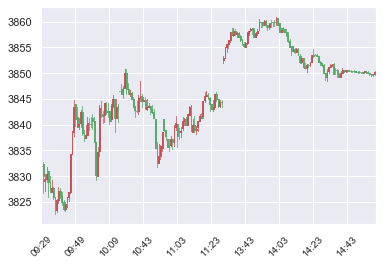

In [7]:
test('../data/if2004_20200417.csv', encoding='utf8')

In [8]:
def print_gap(file, encoding='gb2312', gap=pd.to_timedelta('00:01:00')):
    df = pd.read_csv(file, encoding=encoding)
    datetime = pd.to_datetime(df['业务日期'].astype('str') + ' ' + df['最后修改时间'].astype('str')) + pd.to_timedelta(df['最后修改毫秒']*1000000)
    if len(datetime) == 0:
        return
    for i in range(1, len(datetime)):
        if datetime[i] - datetime[i-1] >= gap or datetime[i] < datetime[i-1]:
            print(datetime[i-1])
            print('__________________________')
            print(datetime[i])
    
    print(datetime[len(datetime)-1])

In [9]:
print_gap('../data/if2004_20200417.csv', encoding='utf8')

2020-04-17 07:47:54
__________________________
2020-04-17 09:29:00.500000
2020-04-17 09:29:00.500000
__________________________
2020-04-17 09:30:01
2020-04-17 11:30:00.500000
__________________________
2020-04-17 13:00:01.500000
2020-04-17 15:00:01.500000


In [10]:
def draw_gap(file, encoding='gb2312'):
    df = pd.read_csv(file, encoding=encoding)
    _, ax = plt.subplots()
    dt = pd.to_datetime(df['最后修改时间'].astype(str)) + pd.to_timedelta(df['最后修改毫秒'] * 1000000)
    dt.hist(ax=ax)
    ax.xaxis.set_tick_params(rotation=45, labelsize=10)

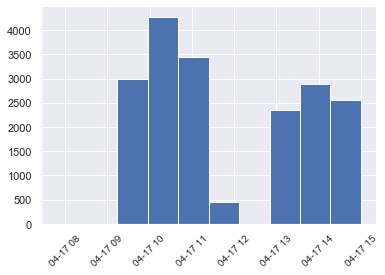

In [11]:
draw_gap('../data/if2004_20200417.csv', encoding='utf8')